In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [12]:
train_df = pd.read_csv("../dataset/train_df_v2.csv")
test_df  = pd.read_csv("../dataset/test_df_v2.csv")

In [13]:

dupes = train_df.merge(
    test_df[['parent_asin', 'user_id']],
    on=['parent_asin', 'user_id'],
    how='inner'
)[['parent_asin', 'user_id']]

train_df = train_df.merge(
    dupes,
    on=['parent_asin', 'user_id'],
    how='left',
    indicator=True
)
train_df = train_df[train_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [4]:
X_train = train_df.drop(columns=['exists', 'parent_asin', 'user_id'])
y_train = train_df['exists']

X_test = test_df.drop(columns=['exists', 'parent_asin', 'user_id'])
y_test = test_df['exists']

In [5]:
X_sample, _, y_sample, _ = train_test_split(
    X_train,
    y_train,
    test_size=0.7, 
    shuffle=True,
    stratify=y_train)

In [6]:
parameters = {
    'n_estimators': randint(300, 700),
    'max_depth': randint(20, 35),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(2, 8),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False, True]
}

model = RandomForestClassifier(random_state=42)

grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=parameters,
    n_iter=5,
    cv=2,
    scoring='f1',
    verbose=4,
    n_jobs=-1,
    random_state=42
)

grid_search.fit(X_sample, y_sample)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002557BDEAEA0>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002557C55D040>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002557C55CFB0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002557BDD7140>},
                   random_state=42, scoring='f1', verbose=4)

In [7]:
best = grid_search.best_estimator_
best.fit(X_train, y_train)
print(best.get_params())

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 25, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 593, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [8]:
y_pred = best.predict(X_test)
y_prob = best.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy : {accuracy:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

Accuracy : 0.5128
F1-score : 0.0503
Precision: 0.9901
Recall   : 0.0258


AUC/ROC: 0.7484


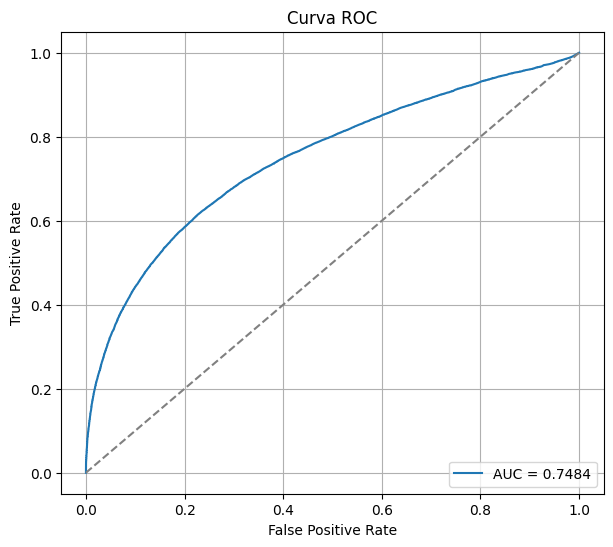

In [9]:

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC/ROC: {roc_auc:.4f}")

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

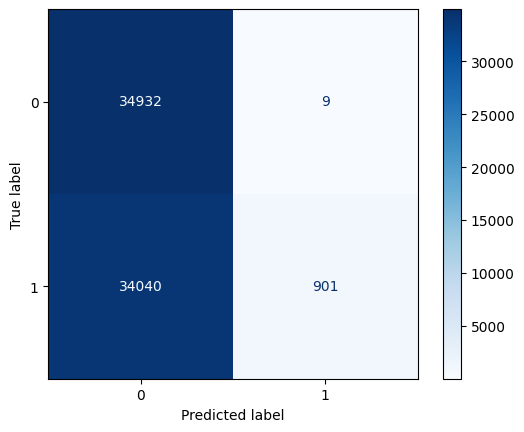

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
import joblib

joblib.dump(model, "model.pkl")